Study of the CMS distribution

# Import

In [1]:
import sys, os, pickle
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import itertools
import json
from IPython.display import IFrame, Image, display
from multiprocessing import Pool

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import col_dic, plot_gridVarQ2
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
from categoriesDef import categories
cat = categories['low']

catText = rt.TText(0.8, 0.9, 'Category: ' + cat.name)
catText.SetNDC()
catText.SetTextAlign(31)
catText.SetTextFont(43)
catText.SetTextSize(30)

In [4]:
m_mu = 0.10565837 #1e-3*Particle.from_string('D0').mass
print m_mu
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_D0 = 1.86962
m_pi = 0.13957018

0.10565837
2.01026
5.27963


# Define binning

In [5]:
binning = {
    'q2'      : array('d', [-2, 1.5, 4, 6, 12]),
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, 0.8, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 1.6, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.4)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.2, 0.4)) + [6] ),
    ],
    'Est_mu'  : [
        array('d', [0.5] + list(np.arange(0.8, 2.3, 0.1)) + [2.5] ),
        array('d', [0.5] + list(np.arange(0.8, 2.5, 0.1)) + [2.5] ),
        [20, 0.50, 2.500],
        [20, 0.50, 2.500],
    ]
}

# Create histograms file

In [6]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Hc'   : '../data/cmsMC_private/BPH_Tag-B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Dstst': '../data/cmsMC_private/BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root'
}

In [9]:
from B02DstMu_selection import candidate_selection, trigger_selection

def create_dSet(inputs, serial=False):
    n = inputs[0]
    filepath = inputs[1]
#     dSet = inputs[2]
    
    print n
    fskimmed_name = 'tmp/' + n + '_MC_' + cat.name + '.root'
    if os.path.isfile(fskimmed_name) and not n in recreate:
        dSet[n] = rtnp.root2array(fskimmed_name)
        N_accepted_tot = len(dSet[n])
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
        N_cand_in = tree.GetEntries()
        print n, ': Number of candidate events:', N_cand_in
    
        if serial:
            pb = ProgressBar(maxEntry=N_cand_in)
        else:
            perc = int(N_cand_in*0.1)
            
        leafs_names = ['q2', 'Est_mu', 'M2_miss']
        leafs_names += ['MC_q2', 'MC_Est_mu', 'MC_M2_miss']
        leafs_names += ['trgMu_pt', 'trgMu_sigdxy']
        leafs_names += ['B_pt', 'B_eta', 'B_phi']
        leafs_names += ['MC_B_pt', 'MC_B_eta', 'MC_B_phi']
        leafs_names += ['MC_Dst_pt', 'MC_Dst_eta', 'MC_Dst_phi']
        leafs_names += ['MC_mu_pt', 'MC_mu_eta', 'MC_mu_phi']
        leafs_names += ['D0_pt', 'D0_eta', 'D0_phi']
        leafs_names += ['mu_pt', 'mu_eta', 'mu_phi']
        leafs_names += ['pis_pt', 'pis_eta', 'pis_phi']
        if n in ['tau', 'mu']:
            leafs_names += ['wh_CLNCentral', 
                            'wh_CLNR0Down', 'wh_CLNR0Up', 
                            'wh_CLNR1Down', 'wh_CLNR1Up', 
                            'wh_CLNR2Down', 'wh_CLNR2Up', 
                            'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']
            
        N_accepted_cand = []
        N_accepted_tot = 0
        output = np.zeros((N_cand_in, len(leafs_names)))
        for i_ev, ev in enumerate(tree):
            if serial:
                pb.show(i_ev)
            elif i_ev % perc == 0:
                print n, ': {:.0f}%'.format(100*(i_ev+1)/maxEntry)
            N_acc = 0
                
            for j in range(ev.pval_piK.size()):
                if not candidate_selection(j, ev):
                    continue
                
                idxTrg = int(ev.mu_trgMu_idx[j])
                if not trigger_selection(idxTrg, ev, cat): 
                    continue
                    
                N_acc += 1
                aux = (ev.q2_D0pismu[j], ev.Est_mu_D0pismu[j], ev.M2_miss_D0pismu[j])
                aux += (ev.MC_q2, ev.MC_Est_mu, ev.MC_M2_miss)
                aux += (ev.trgMu_pt[idxTrg], ev.trgMu_sigdxy[idxTrg])
                aux += (ev.B_D0pismu_pt[j], ev.B_D0pismu_eta[j], ev.B_D0pismu_phi[j])

                aux += (ev.MC_B_pt, ev.MC_B_eta, ev.MC_B_phi)
                aux += (ev.MC_Dst_pt, ev.MC_Dst_eta, ev.MC_Dst_phi)
                aux += (ev.MC_mu_pt, ev.MC_mu_eta, ev.MC_mu_phi)
                aux += (ev.D0_refitD0pismu_pt[j], ev.D0_refitD0pismu_eta[j], ev.D0_refitD0pismu_phi[j])
                aux += (ev.mu_refitD0pismu_pt[j], ev.mu_refitD0pismu_eta[j], ev.mu_refitD0pismu_phi[j])
                aux += (ev.pis_refitD0pismu_pt[j], ev.pis_refitD0pismu_eta[j], ev.pis_refitD0pismu_phi[j])
                if n in ['tau', 'mu']:
                    aux += (
                           ev.wh_CLNCentral,
                           ev.wh_CLNR0Down, ev.wh_CLNR0Up,
                           ev.wh_CLNR1Down, ev.wh_CLNR1Up,
                           ev.wh_CLNR2Down, ev.wh_CLNR2Up,
                           ev.wh_CLNRhoSqDown, ev.wh_CLNRhoSqUp,
                    )

                output[N_accepted_tot] = aux
                N_accepted_tot += 1
            
            if N_acc > 0:
                N_accepted_cand.append(N_acc)
            
        output = output[:N_accepted_tot]
        print n, ': Loop done'
            
        dSet[n] = pd.DataFrame(output, columns=leafs_names)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dSet[n].to_records(), fskimmed_name, treename='Tevts', mode='RECREATE')
        
    print n, ': Events:', N_accepted_tot
    print ''

In [10]:
dSet = {}
recreate = [] #file_loc.keys()
inputs = [[n, fp] for n, fp in file_loc.iteritems()]

# p = Pool(len(inputs))
# out = p.map(create_dSet, inputs) 

for i in inputs:
    create_dSet(i, serial=True)

mu
mu : Events: 132460

tau
tau : Events: 18125

Dstst
Dstst : Events: 3953

Hc
Hc : Events: 4997



In [11]:
class LorentzVector(object):
    def __init__(self):
        pass
    
    def From_p4(self, p4):
        self.p4 = p4
        return self
    
    def From_dSet(self, d, tag, mass):
        self.mass = mass
        px = d[tag+'_pt']*np.cos(d[tag+'_phi'])
        py = d[tag+'_pt']*np.sin(d[tag+'_phi'])
        pz = d[tag+'_pt']*np.sinh(d[tag+'_eta'])
        e = np.hypot(mass, d[tag+'_pt']*np.cosh(d[tag+'_eta']))
        self.p4 = np.column_stack((e, px, py, pz))
        return self
        
    def P(self):
        return np.sqrt(np.sum(np.square(self.p4[:, 1:]), axis=-1))
    
    def Pt(self):
        return np.hypot(self.p4[:, 2], self.p4[:, 1])
    
    def Pz(self):
        return self.p4[:, 3]
    
    def M(self):
        e2 = np.square(self.p4[:,0])
        p2 = np.sum(np.square(self.p4[:, 1:]), axis=-1)
        return np.sqrt(e2 - p2)
    
    def Phi(self):
        return np.arctan2(self.p4[:,2], self.p4[:,1])
    
    def Eta(self):
        return np.arctanh(self.Pz()/self.P())
    
    def Boost(self, LL):
        new = LorentzVector()
        new_p4 = np.einsum('...jk,...k', LL, self.p4)
        return new.From_p4(new_p4)
    
    def __add__(self, other):
        new = LorentzVector()
        new.From_p4(self.p4 + other.p4)
        return new
    
    def __sub__(self, other):
        new = LorentzVector()
        new.From_p4(self.p4 - other.p4)
        return new
    
    def __neg__(self, other):
        new = LorentzVector()
        new.From_p4(-self.p4)
        return new

In [12]:
def LambdaLorentz(gamma, beta, nx, ny, nz):
    L = np.zeros((gamma.shape[0], 4, 4))
    L[:,0,0] = gamma
    L[:,0,1] = -gamma*beta*nx
    L[:,0,2] = -gamma*beta*ny
    L[:,0,3] = -gamma*beta*nz
    
    L[:,1,0] = L[:,0,1]
    L[:,1,1] = 1 + (gamma-1)*nx*nx
    L[:,1,2] = (gamma-1)*nx*ny
    L[:,1,3] = (gamma-1)*nx*nz
    
    L[:,2,0] = L[:,0,2]
    L[:,2,1] = L[:,1,2]
    L[:,2,2] = 1 + (gamma-1)*ny*ny
    L[:,2,3] = (gamma-1)*ny*nz
    
    L[:,3,0] = L[:,0,3]
    L[:,3,1] = L[:,1,3]
    L[:,3,2] = L[:,2,3]
    L[:,3,3] = 1 + (gamma-1)*nz*nz
    
    return L

In [13]:
def computeCMSvars(d):
    out = {}
    
    B_p = d['MC_B_pt']*np.cosh(d['MC_B_eta'])
    out['B_p'] = B_p
    gamma = np.hypot(B_p, m_B0)/m_B0
    beta = B_p / np.hypot(B_p, m_B0)
    theta = 2*np.arctan(np.exp(-d['MC_B_eta']))
    
    nx = np.sin(theta)*np.cos(d['MC_B_phi'])
    ny = np.sin(theta)*np.sin(d['MC_B_phi'])
    nz = np.cos(theta)
    out['nz'] = nz
    out['nt'] = np.hypot(nx, ny)
    
    LL = LambdaLorentz(gamma, beta, nx, ny, nz)
    
    Mu = LorentzVector()
    Mu.From_dSet(d, 'MC_mu', m_mu)
    Dst = LorentzVector()
    Dst.From_dSet(d, 'MC_Dst', m_Dst)
    
    Vis = Dst + Mu
    out['mVis'] = Vis.M()
    
    stVis = Vis.Boost(LL)
    out['pstVis'] = stVis.P()
    out['mCheck'] = stVis.M()
    
    out['cosTheta_st'] = stVis.Pz()/stVis.P()
    out['sinTheta_st'] = stVis.Pt()/stVis.P()
    
    Mu_reco = LorentzVector()
    Mu_reco.From_dSet(d, 'mu', m_mu)
    D0_reco = LorentzVector()
    D0_reco.From_dSet(d, 'D0', m_D0)
    pis_reco = LorentzVector()
    pis_reco.From_dSet(d, 'pis', m_pi)
    Vis_reco = D0_reco + Mu_reco + pis_reco
    out['mVis_reco'] = Vis_reco.M()
    
    B_reco = LorentzVector()
    B_reco.From_dSet(d, 'B', m_B0)

    pVis_proj = np.einsum('...i,...i', B_reco.p4[:,1:], Vis_reco.p4[:,1:])/B_reco.P()
    out['B_p_proj'] = pVis_proj * m_B0 / Vis_reco.M()
    
    return out

In [14]:
dSetAdd = {}
for n,d in dSet.iteritems():
    dSetAdd[n] = computeCMSvars(d)

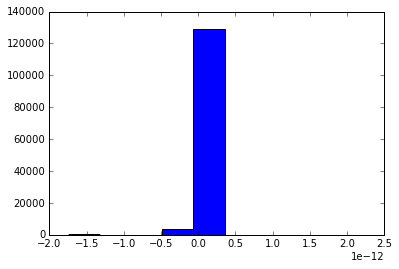

In [15]:
_ = plt.hist(dSetAdd['mu']['mVis'] - dSetAdd['mu']['mCheck'])

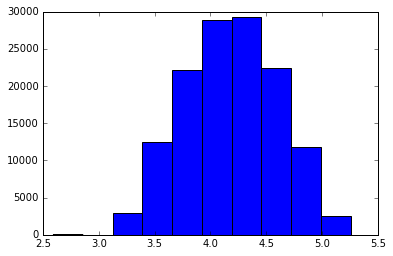

In [16]:
_ = plt.hist(np.hypot(dSetAdd['mu']['mVis'], dSetAdd['mu']['pstVis']))

0.2930458028169571
0.2922051067077254


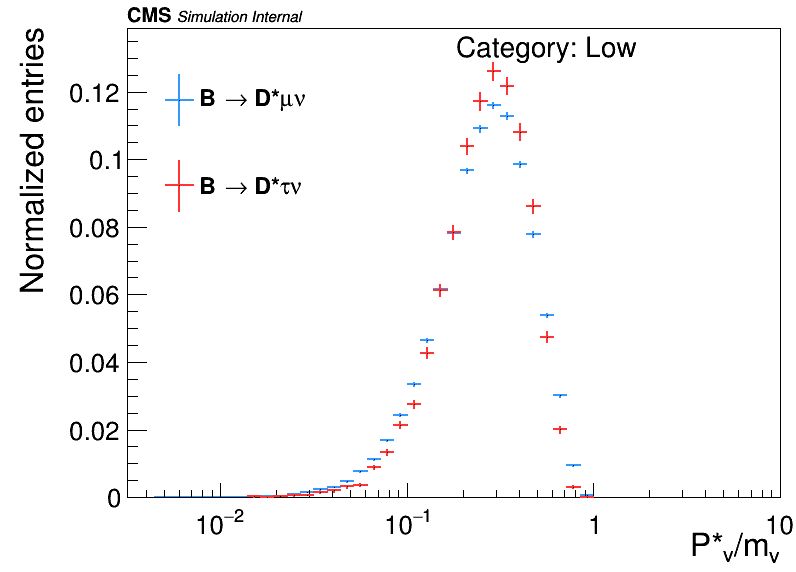

In [17]:
hl = []
leg = rt.TLegend(0.2, 0.6, 0.4, 0.9)
leg.SetBorderSize(0)
for n, d in dSetAdd.iteritems():
    if n not in ['mu', 'tau']: continue
    var = d['pstVis']/d['mVis']
    h = create_TH1D(var, 
                    binning = np.logspace(-2.5,1,50),
                    axis_title = ['P*_{v}/m_{v}', 'Normalized entries']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], 'B #rightarrow D*#{}#nu'.format(n), 'lep')
    print np.mean(var)
    
SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()
catText.Draw()

0.8157068650413575
0.8220643250456569
0.8192087798159542
0.8009049657886584


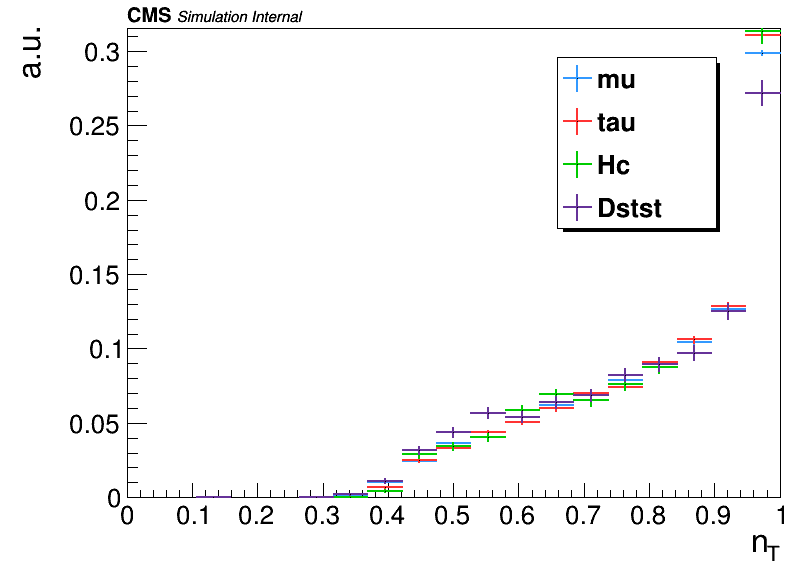

In [18]:
hl = []
leg = rt.TLegend(0.7, 0.6, 0.9, 0.9)
for n, d in dSet.iteritems():
    lv = LorentzVector()
    lv.From_dSet(d, 'MC_B', m_B0)
    var = lv.Pt()/lv.P()
    h = create_TH1D(var, 
                    binning = np.linspace(0,1,20),
                    axis_title = ['n_{T}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

0.488818405875798
0.47922843676734883
0.480810447553881
0.5090489669452922


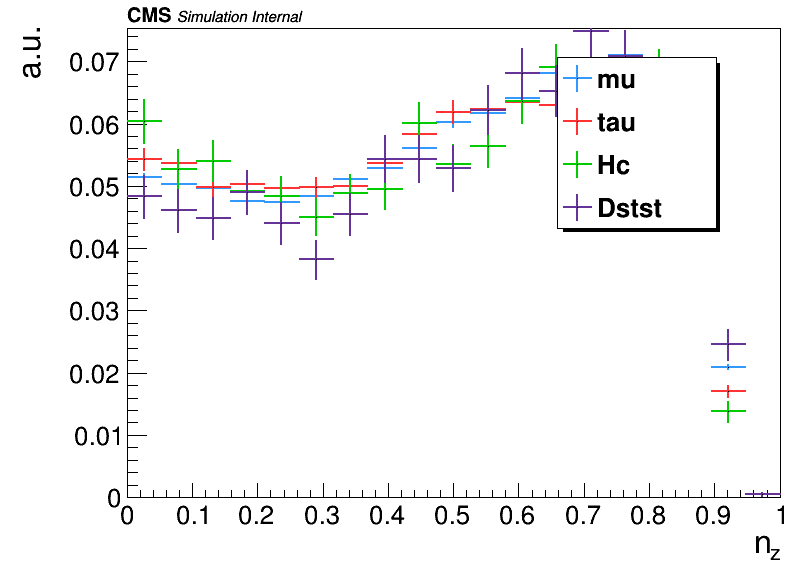

In [19]:
hl = []
leg = rt.TLegend(0.7, 0.6, 0.9, 0.9)
for n, d in dSet.iteritems():
    lv = LorentzVector()
    lv.From_dSet(d, 'MC_B', m_B0)
    var = np.abs(lv.Pz())/lv.P()
    h = create_TH1D(var, 
                    binning = np.linspace(0,1,20),
                    axis_title = ['n_{z}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

5.929931412933899
7.5158079097785455
8.050119412239246
6.037273638573166


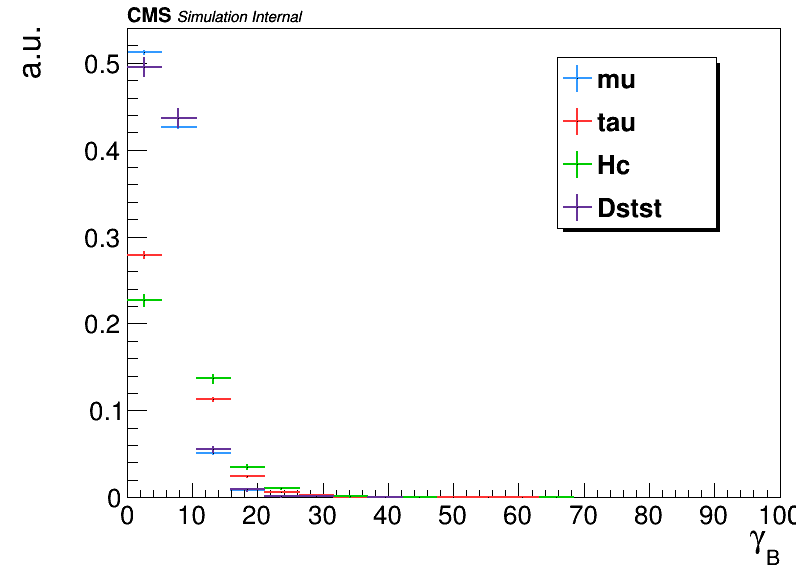

In [20]:
hl = []
leg = rt.TLegend(0.7, 0.6, 0.9, 0.9)
for n, d in dSet.iteritems():
    lv = LorentzVector()
    lv.From_dSet(d, 'MC_B', m_B0)
    var = lv.p4[:,0]/m_B0
    h = create_TH1D(var, 
                    binning = np.linspace(0,100,20),
                    axis_title = ['#gamma_{B}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

0.05484110069785358
0.05236272596628983
0.041172811314142986
0.047477161853038664


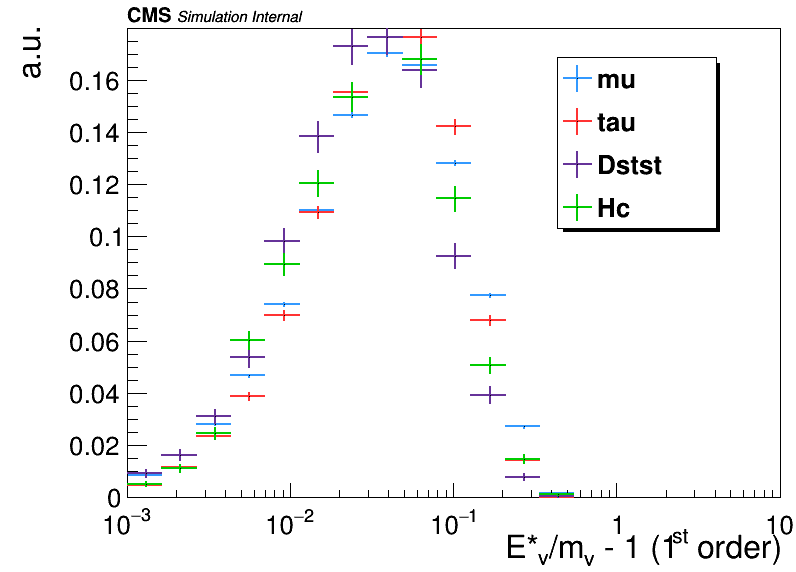

In [21]:
hl = []
leg = rt.TLegend(0.7, 0.6, 0.9, 0.9)
for n, d in dSetAdd.iteritems():
    var = 0.5*np.square(d['pstVis']/d['mVis'])
    h = create_TH1D(var, 
                    binning = np.logspace(-3,1,20),
                    axis_title = ['E*_{v}/m_{v} - 1 (1^{st} order)', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()

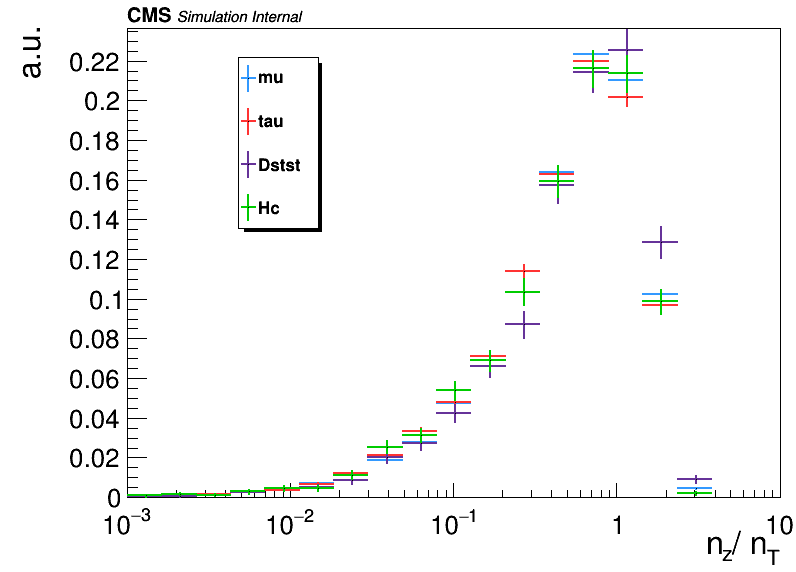

In [22]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    h = create_TH1D(d['nz']/d['nt'], 
                    binning = np.logspace(-3,1,20),
                    axis_title = ['n_{z}/ n_{T}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()

0.022731299671466042
0.014651412026777078
0.02223508680871249
0.013030489513502866


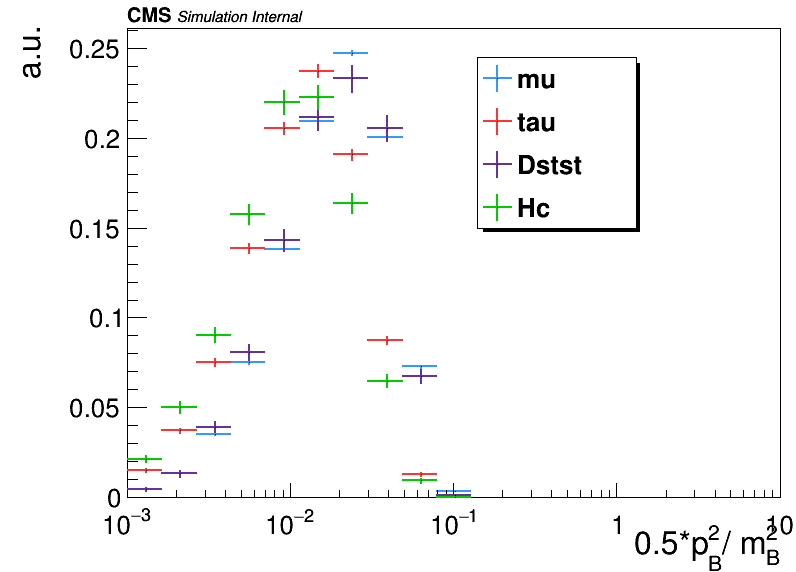

In [23]:
hl = []
leg = rt.TLegend(0.6, 0.6, 0.8, 0.9)
for n, d in dSetAdd.iteritems():
    var = 0.5*np.square(m_B0/d['B_p'])
    h = create_TH1D(var, 
                    binning = np.logspace(-3,1,20),
                    axis_title = ['0.5*p_{B}^{2}/ m_{B}^{2}', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogx()
leg.Draw()

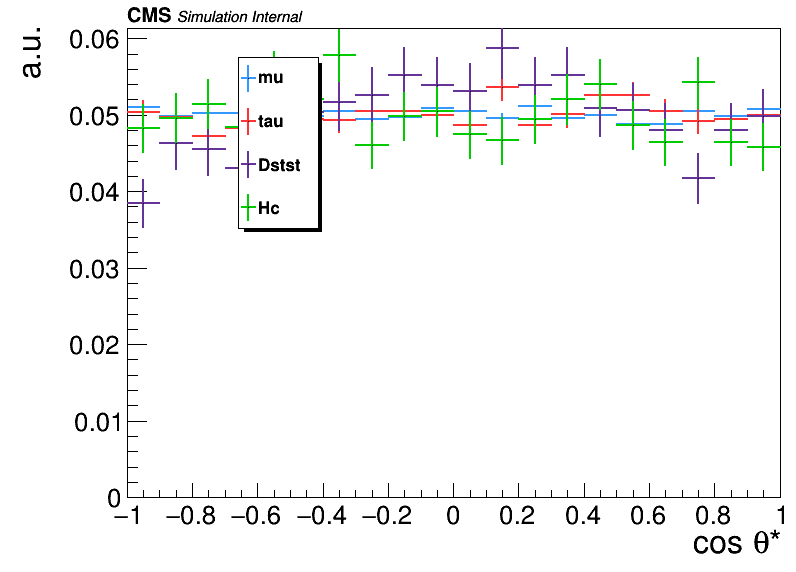

In [24]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    h = create_TH1D(d['cosTheta_st'], 
                    binning = [20, -1, 1],
                    axis_title = ['cos #theta*', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
hl[0].GetYaxis().SetRangeUser(0, 1.2*hl[0].GetMaximum())
leg.Draw()

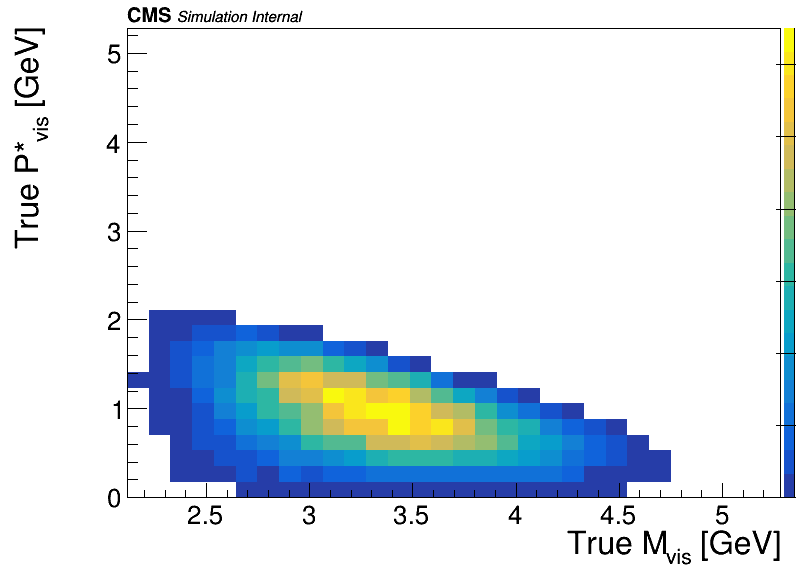

In [25]:
n = 'tau'
d = dSetAdd[n]

h = create_TH2D(np.column_stack((d['mVis'], d['pstVis'])),
                name = n,
                binning=[30, m_mu+m_Dst, m_B0, 30, 0, m_B0],
                axis_title=['True M_{vis} [GeV]', 'True P*_{vis} [GeV]', '']
               )

c =  drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.Draw()

0.05434344784938394 0.19946289768432063
0.05293623168827481 0.18992822070676707
0.04325307700282108 0.16596777733034337
0.04443132421967916 0.18142058272792924


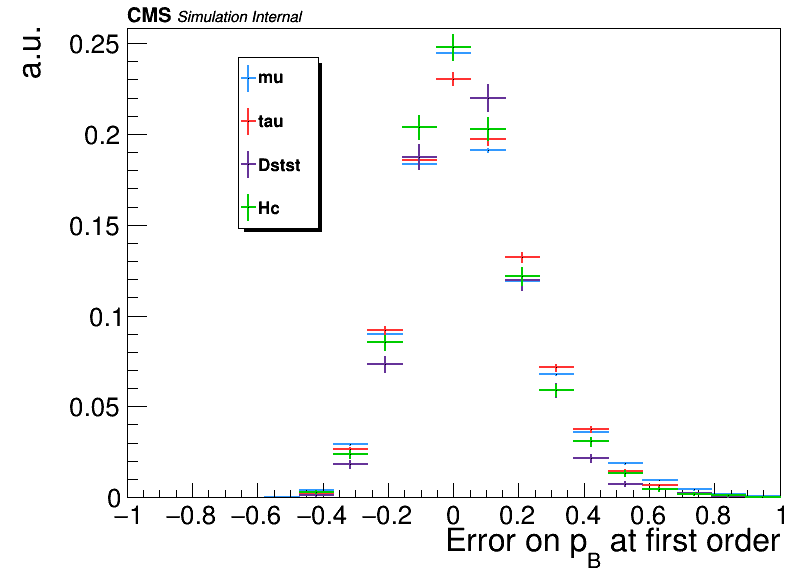

In [26]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = 1+0.5*np.square(m_B0/d['B_p'])
    var *= d['cosTheta_st']*d['pstVis']/d['mVis']
    var += 0.5*np.square(d['pstVis']/d['mVis'])
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on p_{B} at first order', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var), np.std(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
# c.SetLogx()
leg.Draw()

0.13257667332023726 0.21007527130801779
0.13748217344201125 0.19991886872980277
0.14093981954896964 0.17763880164959517
0.09298806237738053 0.1968521443448257


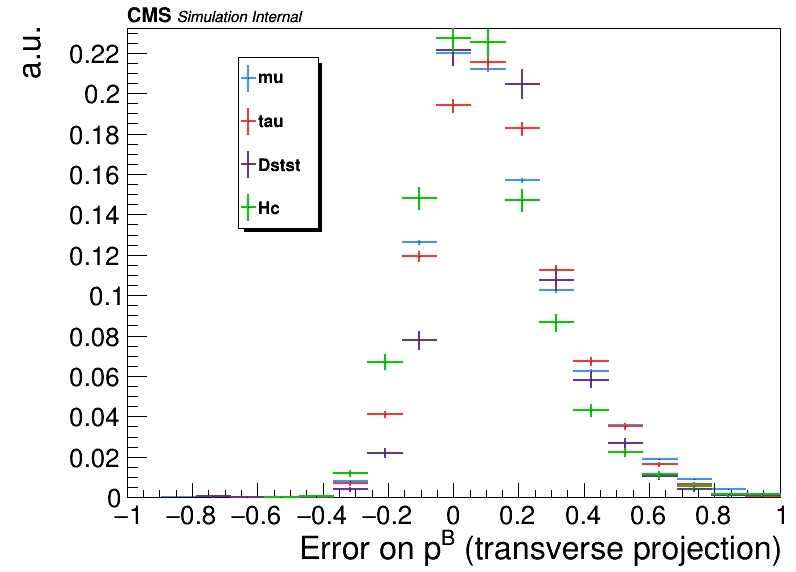

In [27]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = dSet[n]['B_pt']*np.cosh(dSet[n]['B_eta']) 
    var = (var - d['B_p'])/d['B_p']
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on p^{B} (transverse projection)', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var), np.std(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

0.12800910265415805 0.20736822642773037
0.13355391797528238 0.198325177335886
0.13640248017218848 0.17555442320208256
0.09048075820851004 0.19563146873174342


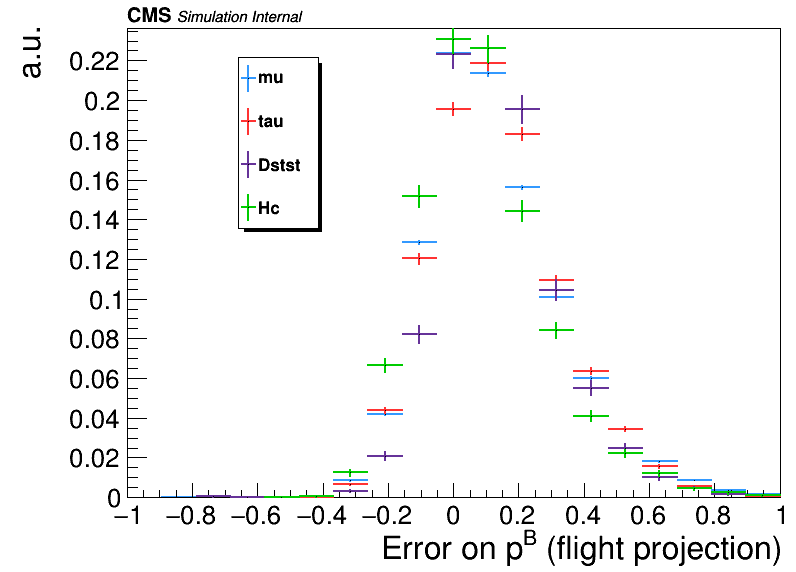

In [28]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = (d['B_p_proj']-d['B_p'])/d['B_p']
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on p^{B} (flight projection)', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var), np.std(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

0.001215517553425898
0.0016288282103872197
0.001403417651811465
0.001663010709962431


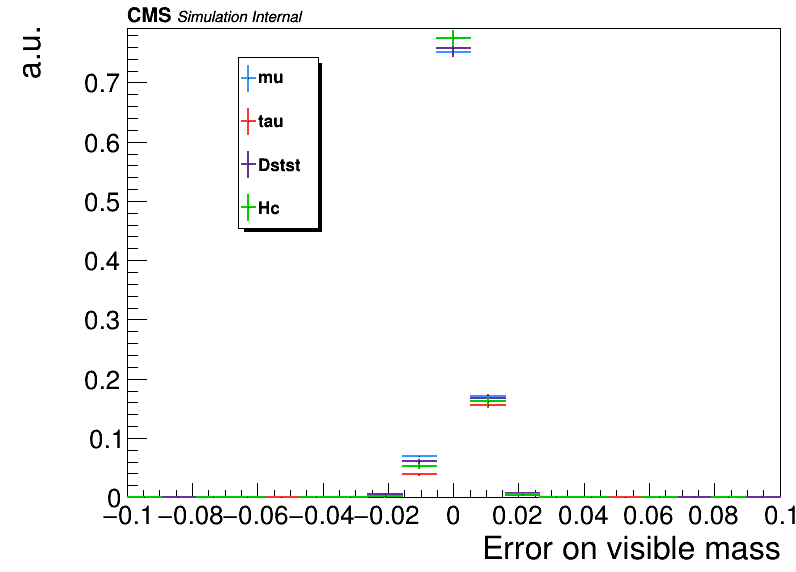

In [29]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSetAdd.iteritems():
    var = (d['mVis_reco']-d['mVis'])/d['mVis']
    h = create_TH1D(var, 
                    binning = np.linspace(-0.1,0.1,20),
                    axis_title = ['Error on visible mass', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print np.mean(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

mu 0.15228008908466842 2.5524862073233514 -104.40601889470811 175.61003401684408
tau 0.0006627797086105 0.2146324494464371 -1.4929351923659469 1.4440736953802675
Hc 0.06421689944898525 0.3436965473839801 -1.4952039165486588 1.7401105219759307
Dstst -0.01654144922103165 0.4131239529621468 -2.5729543748218013 6.4318464892605185


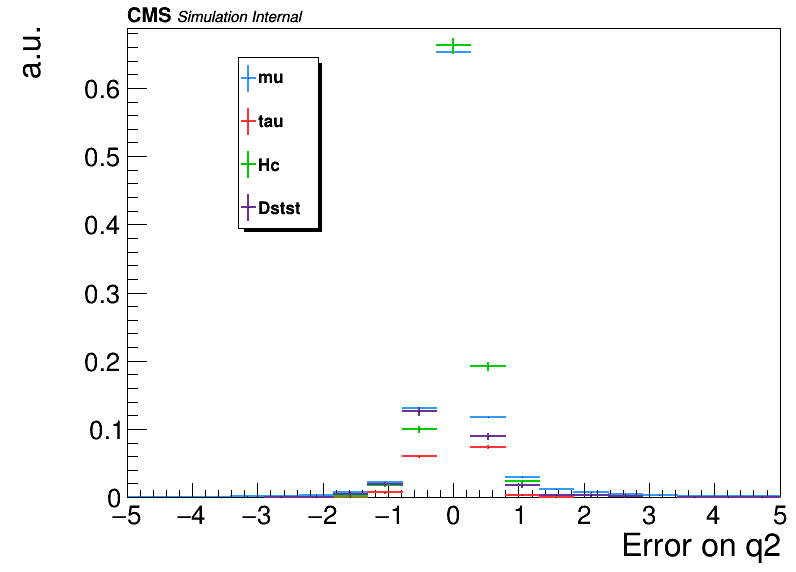

In [30]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSet.iteritems():
    var = (d['q2']-d['MC_q2'])/d['MC_q2']
    h = create_TH1D(var, 
                    binning = np.linspace(-5,5,20),
                    axis_title = ['Error on q2', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print n, np.mean(var), np.std(var), np.min(var), np.max(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

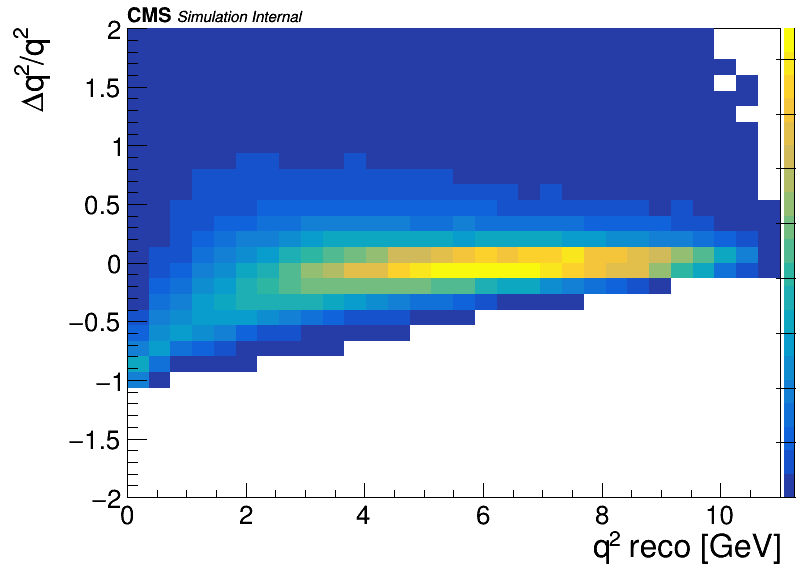

In [31]:
n = 'mu'
d = dSet[n]

var = (d['q2']-d['MC_q2'])/d['MC_q2']
h = create_TH2D(np.column_stack((d['q2'], var)),
                name = n,
                binning=[30, 0, 11, 30, -2, 2],
                axis_title=['q^{2} reco [GeV]', '#Deltaq^{2}/q^{2}', '']
               )

c =  drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.Draw()

mu 0.4187859533881409 1.4807388360365301 -52.018328314534756 8.548936974711296
tau 0.2695381892966235 1.454156163802938 -29.170676946640015 6.54367995262146
Hc 0.17536825188256755 1.315314584674463 -20.873734563589096 7.294211000204086
Dstst 0.33637622951494106 1.3307329947688058 -20.769427686929703 6.370254427194595


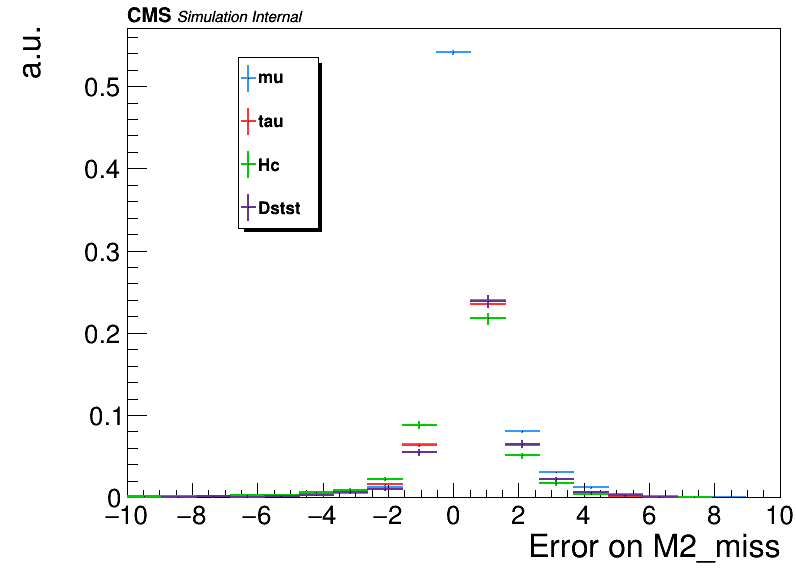

In [32]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSet.iteritems():
    var = (d['M2_miss']-d['MC_M2_miss'])
    h = create_TH1D(var, 
                    binning = np.linspace(-10,10,20),
                    axis_title = ['Error on M2_miss', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print n, np.mean(var), np.std(var), np.min(var), np.max(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

mu -0.02975141194555904 0.11596088489051913 -0.7598255353568604 3.180635954830501
tau -0.0293392967093897 0.12882915959441427 -0.6429491474285517 1.9699949198510105
Hc 0.009076408284668361 0.13780104817326413 -0.7921370434020399 2.125939315582097
Dstst -0.0373045799071437 0.11321136994276852 -0.7718082091311522 1.652541849917048


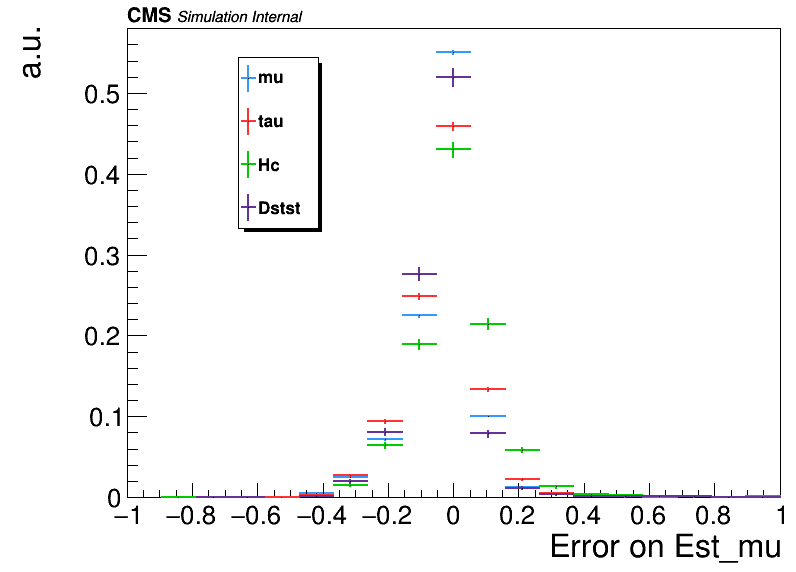

In [33]:
hl = []
leg = rt.TLegend(0.3, 0.6, 0.4, 0.9)
for n, d in dSet.iteritems():
    var = (d['Est_mu']-d['MC_Est_mu'])/d['MC_Est_mu']
    h = create_TH1D(var, 
                    binning = np.linspace(-1,1,20),
                    axis_title = ['Error on Est_mu', 'a.u.']
                   )
    h.SetLineColor(col_dic[n])
    h.Scale(1./h.Integral())
    hl.append(h)
    leg.AddEntry(hl[-1], n, 'lep')
    print n, np.mean(var), np.std(var), np.min(var), np.max(var)
    
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

## Uncertainty on direction

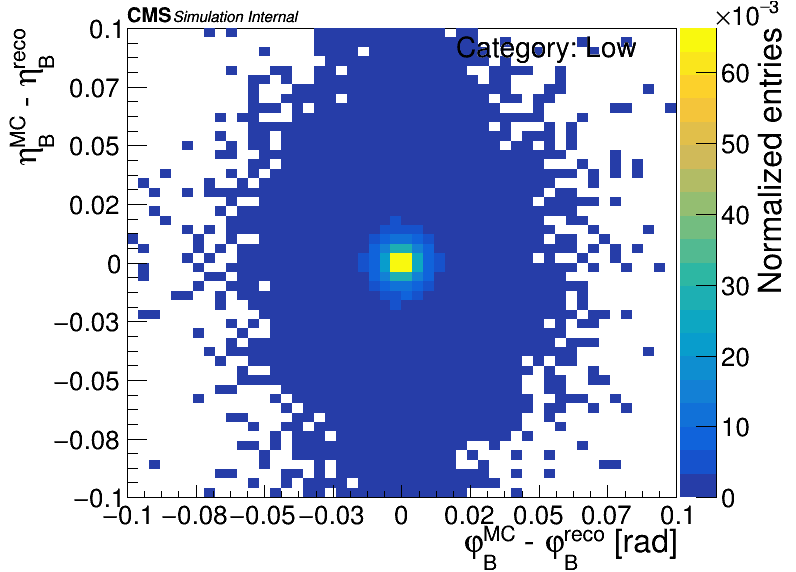

In [34]:
n = 'mu'
d = dSet[n]

dPhi = d['MC_B_phi'] - d['B_phi']
dPhi = np.where(np.abs(dPhi) > np.pi, dPhi - np.sign(dPhi)*2*np.pi, dPhi)
dEta = d['MC_B_eta'] - d['B_eta']

h = create_TH2D(np.column_stack((dPhi, dEta)),
                name = n,
                binning=[50, -0.1, 0.1, 50, -0.1, 0.1],
                axis_title=['#varphi_{B}^{MC} - #varphi_{B}^{reco} [rad]', 
                            '#eta_{B}^{MC} - #eta_{B}^{reco}', 
                            'Normalized entries']
               )
h.Scale(1./h.Integral())
rt.TGaxis.SetMaxDigits(3)

rt.gStyle.SetPadRightMargin(0.15)
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
h.GetZaxis().SetTitleOffset(0.7)
h.GetXaxis().SetNdivisions(-408)
h.GetYaxis().SetNdivisions(-408)
catText.Draw()

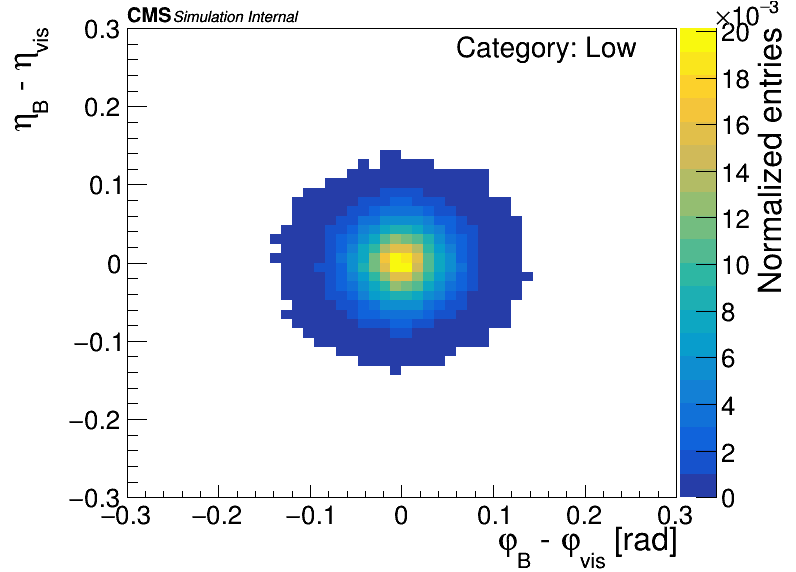

In [35]:
n = 'mu'
d = dSet[n]

Mu = LorentzVector()
Mu.From_dSet(d, 'MC_mu', m_mu)
Dst = LorentzVector()
Dst.From_dSet(d, 'MC_Dst', m_Dst)
pVis = Mu + Dst
dPhi = d['MC_B_phi'] - pVis.Phi()
dPhi = np.where(np.abs(dPhi) > np.pi, dPhi - np.sign(dPhi)*2*np.pi, dPhi)
dEta = d['MC_B_eta'] - pVis.Eta()

h = create_TH2D(np.column_stack((dPhi, dEta)),
                name = n,
                binning=[50, -0.3, 0.3, 50, -0.3, 0.3],
                axis_title=['#varphi_{B} - #varphi_{vis} [rad]', '#eta_{B} - #eta_{vis}', 'Normalized entries']
               )
h.Scale(1./h.Integral())
rt.TGaxis.SetMaxDigits(3)

rt.gStyle.SetPadRightMargin(0.15)
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
h.GetZaxis().SetTitleOffset(0.7)
catText.Draw()